In [1]:
# Add the parent directory to the path so that we can import the src module
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
from src.camera import CameraCalibration, Camera
from src.camera.video import VideoStream
from src.segmentation.circledetector import CircleDetector
from src.pose.position_estimation import PositionEstimation
from src.pingpong.ball import BallConstants
from src.pingpong.table import TableConstants
from src.fileutils import DATA_DIR
from src.camera.intrinsic_matrix import find_single_intrinsic_matrix

from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO

SyntaxError: f-string: expecting '}' (video.py, line 87)

In [3]:
calibration_video = VideoStream(DATA_DIR / 'calibration' / 'Priyanshu_iPhone13.MOV')
print(calibration_video)
find_single_intrinsic_matrix(next(calibration_video), show_image=True)
calibration = CameraCalibration.from_calibration_video(tqdm(calibration_video, total=calibration_video.get_length_if_known()))
calibration.intrinsic_matrix

NameError: name 'VideoStream' is not defined

In [ ]:
camera = Camera(pose=None, calibration=calibration)
ball = BallConstants()
table = TableConstants()
position_estimator = PositionEstimation(camera, ball, table)

In [4]:
ping_pong_ball_close_image_path = DATA_DIR / 'calibration' / 'Priyanshu_iPhone13_Net_Close.png'
ping_pong_ball_far_image_path = DATA_DIR / 'calibration' / 'Priyanshu_iPhone13_Net_Far.png'

# Read images and plot on same plot
ping_pong_ball_close_image = cv2.imread(str(ping_pong_ball_close_image_path))
ping_pong_ball_far_image = cv2.imread(str(ping_pong_ball_far_image_path))

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(ping_pong_ball_close_image, cv2.COLOR_BGR2RGB))
plt.title('Close')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(ping_pong_ball_far_image, cv2.COLOR_BGR2RGB))
plt.title('Far')
plt.axis('off')

plt.show()

NameError: name 'DATA_DIR' is not defined

We know the length of the net. Therefore, we can test our calibration by checking estimates of the close and far ball positions.
In these images, the camera might not have been setup in precisely the same orientation. Therefore, we can expect to see some error.

4 circles detected
1 circles detected after filtering by color threshold


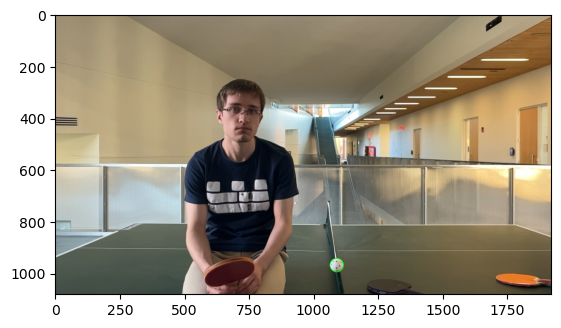

In [6]:
circle_detector = CircleDetector()
circles = circle_detector.hough_circles(ping_pong_ball_close_image, minRadius=10, maxRadius=30, param1=50, param2=30, minDist=20)
print(f"{len(circles)} circles detected")
sensitivity = 50
lower_white = np.array([0,0,255-sensitivity])
upper_white = np.array([255,sensitivity,255])
circles = circle_detector.filter_circles_by_color_threshold(ping_pong_ball_close_image, circles, color_low_hsv=lower_white, color_high_hsv=upper_white, threshold=0.3)
print(f"{len(circles)} circles detected after filtering by color threshold")

aug_img = circle_detector.draw_circles(ping_pong_ball_close_image, circles, color=(0, 255, 0), thickness=2)
_ = plt.imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))


In [7]:
ping_pong_ball = circles[0]
ping_pong_ball_center_x = ping_pong_ball[0]
ping_pong_ball_center_y = ping_pong_ball[1]
ping_pong_ball_radius = ping_pong_ball[2]

print(f'Center: ({ping_pong_ball_center_x}, {ping_pong_ball_center_y}), Radius: {ping_pong_ball_radius}')

ball_position_close = position_estimator.ball_position_camera_reference_frame(ping_pong_ball_center_x, ping_pong_ball_center_y, ping_pong_ball_radius * 2)
print(f'Calculated Ball Position:', ball_position_close)

center_x, center_y, diameter = position_estimator.project_ball_position_camera_reference_frame_to_camera_plane(ball_position_close)

print(f'Projection of ball position: ({center_x}, {center_y}), Radius: {diameter//2}')



Center: (1090, 968), Radius: 26
Calculated Ball Position: [    0.13716     0.26451       1.364]
Projection of ball position: (1090, 968), Radius: 26


1 circles detected
1 circles detected after filtering by color threshold


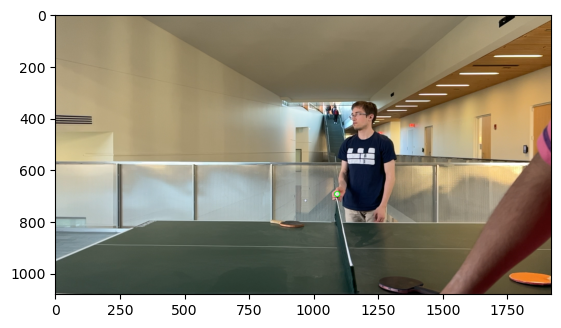

In [8]:
circles = circle_detector.hough_circles(ping_pong_ball_far_image, minRadius=5, maxRadius=20, param1=50, param2=30, minDist=10)
print(f"{len(circles)} circles detected")
sensitivity = 50
lower_white = np.array([0,0,255-sensitivity])
upper_white = np.array([255,sensitivity,255])
circles = circle_detector.filter_circles_by_color_threshold(ping_pong_ball_far_image, circles, color_low_hsv=lower_white, color_high_hsv=upper_white, threshold=0.3)
print(f"{len(circles)} circles detected after filtering by color threshold")

aug_img = circle_detector.draw_circles(ping_pong_ball_far_image, circles, color=(0, 255, 0), thickness=2)
_ = plt.imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))

In [9]:
ping_pong_ball = circles[0]
ping_pong_ball_center_x = ping_pong_ball[0]
ping_pong_ball_center_y = ping_pong_ball[1]
ping_pong_ball_radius = ping_pong_ball[2]

print(f'Center: ({ping_pong_ball_center_x}, {ping_pong_ball_center_y}), Radius: {ping_pong_ball_radius}')

ball_position_far = position_estimator.ball_position_camera_reference_frame(ping_pong_ball_center_x, ping_pong_ball_center_y, ping_pong_ball_radius * 2)
print(f'Calculated Ball Position:', ball_position_far)

center_x, center_y, diameter = position_estimator.project_ball_position_camera_reference_frame_to_camera_plane(ball_position_far)

print(f'Projection of ball position: ({center_x}, {center_y}), Radius: {diameter//2}')


Center: (1092, 694), Radius: 10
Calculated Ball Position: [    0.36062     0.24299      3.5464]
Projection of ball position: (1092, 694), Radius: 10


In [10]:
# In the camera reference frame, we expect the difference 

print(ball_position_far - ball_position_close)
print(f"Expected difference in z-axis: {table.length}")

[    0.22346   -0.021526      2.1824]
Expected difference in z-axis: 2.74
